In [1]:
import ipdb
from tqdm import tqdm
import pandas as pd
import re
from collections import Counter
import math
import numpy as np
from time import sleep
import requests
from requests.adapters import HTTPAdapter, Retry
from util import load_sentences

tqdm.pandas()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(15,10)}, font_scale=3)

import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos')

2025-10-06 14:21:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-10-06 14:21:17 INFO: Downloaded file to /Users/venkat/stanza_resources/resources.json
2025-10-06 14:21:18 INFO: Loading these models for language: en (English):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

2025-10-06 14:21:18 INFO: Using device: cpu
2025-10-06 14:21:18 INFO: Loading: tokenize
2025-10-06 14:21:18 INFO: Loading: mwt
2025-10-06 14:21:18 INFO: Loading: pos
2025-10-06 14:21:19 INFO: Done loading processors!


## Load all the sentences

In [2]:
bl = pd.read_csv('../data/Bulwer-Lytton.tsv', sep='\t', quoting=3)

with open('../data/crowd-sample.txt', 'r', encoding='utf-8') as f: 
    crowd_sents = [x.strip() for x in f.readlines()]
# crowd_df = pd.DataFrame.from_dict({'sentence': crowd_sents}).sample(5000, random_state=1).reset_index(drop=True)
# crowd_sents = crowd_df.sentence.values.tolist()

with open('../fewshot-generation/outputs/gpt5-sents.txt', 'r', encoding='utf-8') as f: 
        gpt5_sents = [x.strip() for x in f.readlines()]

with open('../fewshot-generation/outputs/gpt41-sents.txt', 'r', encoding='utf-8') as f: 
        gpt4_sents = [x.strip() for x in f.readlines()]

with open('../fewshot-generation/outputs/DeepSeek_sents.txt', 'r', encoding='utf-8') as f: 
        deep_sents = [x.strip() for x in f.readlines()]

with open('../fewshot-generation/outputs/gpt-120b_temp_1.txt', 'r', encoding='utf-8') as f: 
        gpt120_sents = [x.strip() for x in f.readlines()]

comb_df = pd.read_csv('../data/humor_datasets/comb/files/test.csv', encoding="utf-8", quoting=0)
comb_df = comb_df[comb_df["label"] == 1]
comb_sents =  comb_df["text"].to_list()
len(crowd_sents)

1000

## Make a dataframe with all unique ANs and their category

In [3]:
def get_ans(sents):
    parsed_sents = nlp('\n\n'.join(sents))

    an_words = []

    for psent in parsed_sents.sentences:
        words = [word.text for word in psent.words]
        poss = [word.upos for word in psent.words]
        for i in range(len(words)-1):
            if poss[i]=='ADJ' and poss[i+1]=='NOUN':
                an_word = ' '.join((words[i], words[i+1]))
                an_words.append(an_word)
    print(len(an_words), end=" ")
    an_words = list(set(an_words))
    print(len(an_words))
    return an_words

bulwer_ans = get_ans(bl.sentence.values.tolist())
crowd_ans = get_ans(crowd_sents)
gpt5_ans = get_ans(gpt5_sents)
gpt4_ans = get_ans(gpt4_sents)
deep_ans = get_ans(deep_sents)
gpt120_ans = get_ans(gpt120_sents)
comb_ans = get_ans(comb_sents)

800 767


In [4]:
an_df = pd.DataFrame(
    {'type': (['BL' for _ in range(len(bulwer_ans))] + 
             ['crowd-humor' for _ in range(len(crowd_ans))] + 
             ['GPT-5' for _ in range(len(gpt5_ans))] + 
             ['GPT-4.1' for _ in range(len(gpt4_ans))] + 
             ['DeepSeek' for _ in range(len(deep_ans))] +
             ['gpt-oss-120b' for _ in range(len(gpt120_ans))] +
             ['combo-first' for _ in range(len(comb_ans))]),
    'an': bulwer_ans + crowd_ans + gpt5_ans + gpt4_ans + deep_ans + gpt120_ans + comb_ans})
an_df.to_csv('an_df_raw.tsv', sep='\t', index=False)

## Counting ANs in Infinigram

In [4]:
an_counts = []

session = requests.Session()
retries = Retry(
    total=5,  # Retry up to 5 times
    backoff_factor=0.5,  # Exponential backoff: 0.5s, 1s, 2s, ...
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["POST"]
)
session.mount('https://', HTTPAdapter(max_retries=retries))

with open('an_counts.txt', 'w') as f:
    for an_word in tqdm(crowd_ans):
        try:
            # The space before ensures that you're only looking for the adjective itself instead of the first token being a subword
            query = ' ' + an_word
            if an_word.lower() not in query:
                query = query + ' OR  ' + an_word.lower()
            if an_word.capitalize() not in query:
                query = query + ' OR  ' + an_word.capitalize()
            payload = {
                'index': 'v4_dclm-baseline_llama',
                'query_type': 'count',
                'query': query,
            }
            response = session.post('https://api.infini-gram.io/', json=payload, timeout=10)
            response.raise_for_status()  # Raise error for bad HTTP status codes
            result = response.json()
            an_counts.append(result.get('count', 0))  # Default to 0 if missing
        except (requests.exceptions.RequestException, ValueError) as e:
            print(f"Error for input {query!r}: {e}")
            an_counts.append("None")  # Or use 0, or skip, depending on needs
            time.sleep(1)  # Optional cooldown on error
        f.write(str(result.get('count', 0))+"\n")

session.close()

100%|████████████████████████████████████████████████████████████████████████████| 767/767 [01:44<00:00,  7.35it/s]


In [5]:
with open('an_counts.txt', 'r') as f:
    an_counts = [int(x.strip()) for x in f.readlines()]
len(an_counts)

767

In [16]:
an_df['count'] = an_counts

In [9]:
an_df.to_csv('an_df_dclm.tsv', sep='\t', index=False)

In [3]:
an_df = pd.read_csv('an_df_dclm.tsv', sep='\t')
an_df.shape

(22555, 3)

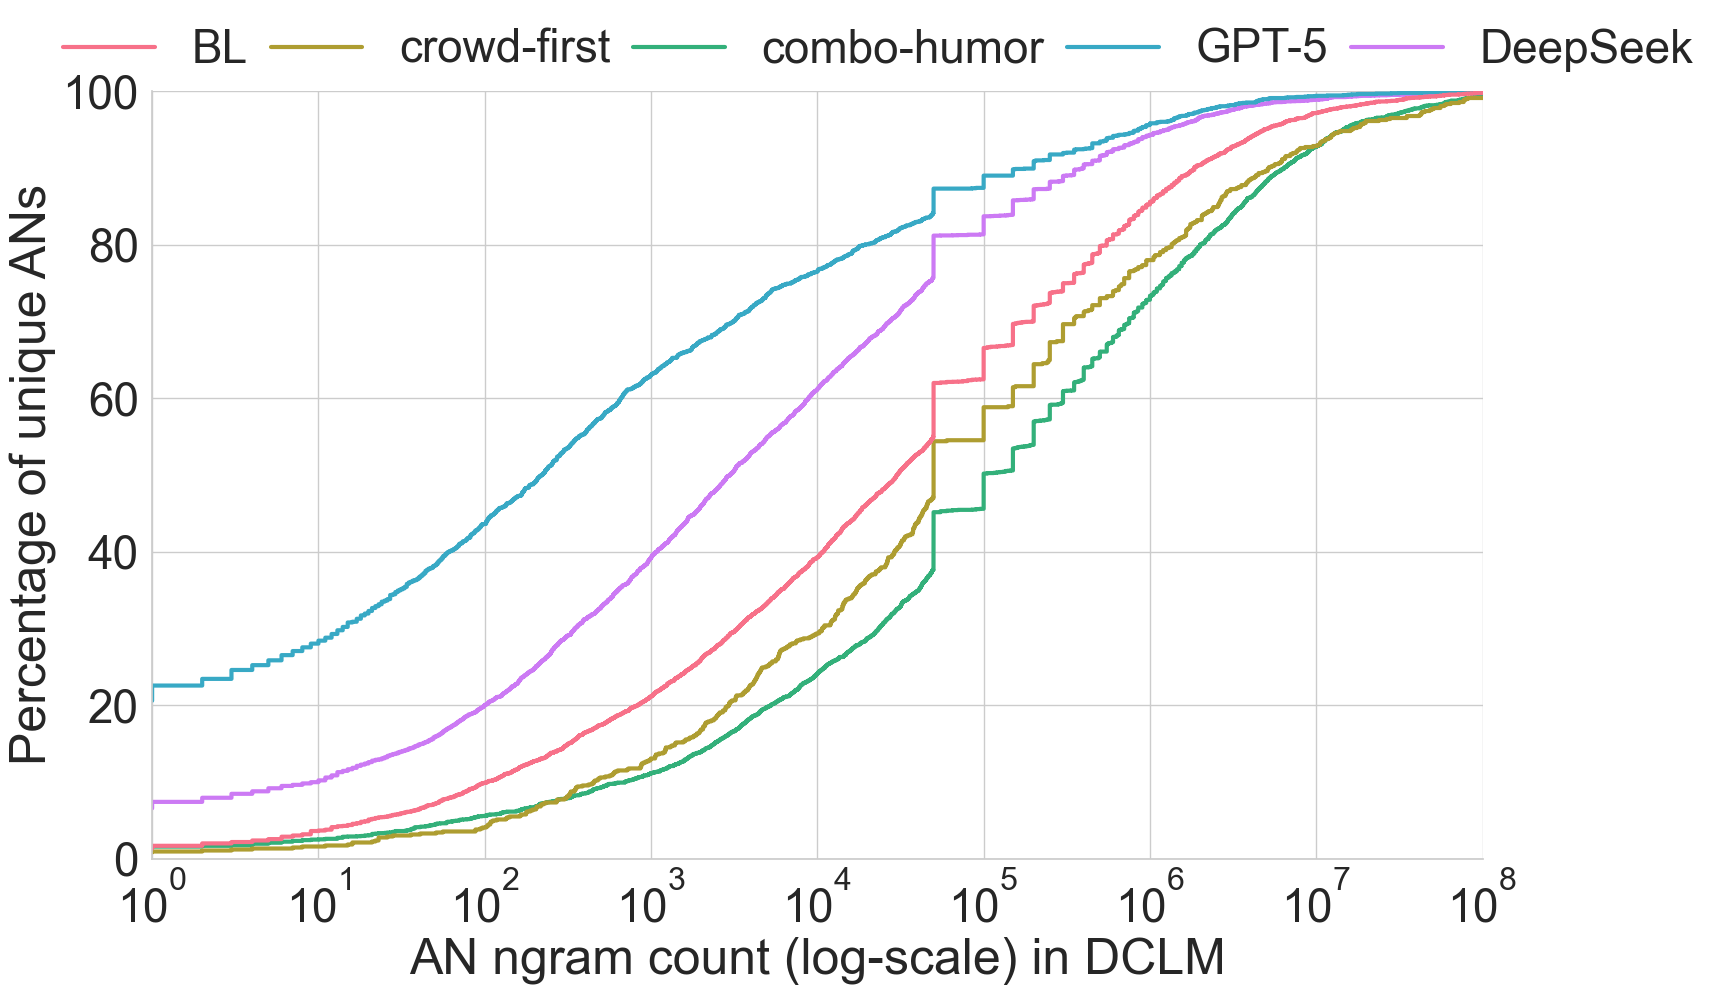

In [7]:
fig = sns.displot(an_df[(an_df.type.isin(['BL', 'crowd-first', 'combo-humor', 'GPT-5', 'DeepSeek']))], hue_order=['BL', 'crowd-first', 'combo-humor', 'GPT-5', 'DeepSeek'], x='count', hue='type', kind='ecdf', aspect=1.6, height=10, palette='husl', stat='percent', log_scale=(True, False), linewidth=3)
fig.set_axis_labels('AN ngram count (log-scale) in DCLM','Percentage of unique ANs')
sns.move_legend(fig, "upper center", bbox_to_anchor=(.45, 1.05), ncol=5, title=None, frameon=False, columnspacing=0.5)
fig.set(yticks=[i for i in range(0,101,20)])
plt.xlim(1, 10**8) 
plt.ylim(0, 100) 
plt.show()
fig.figure.savefig('an-plot.pdf', bbox_inches='tight')

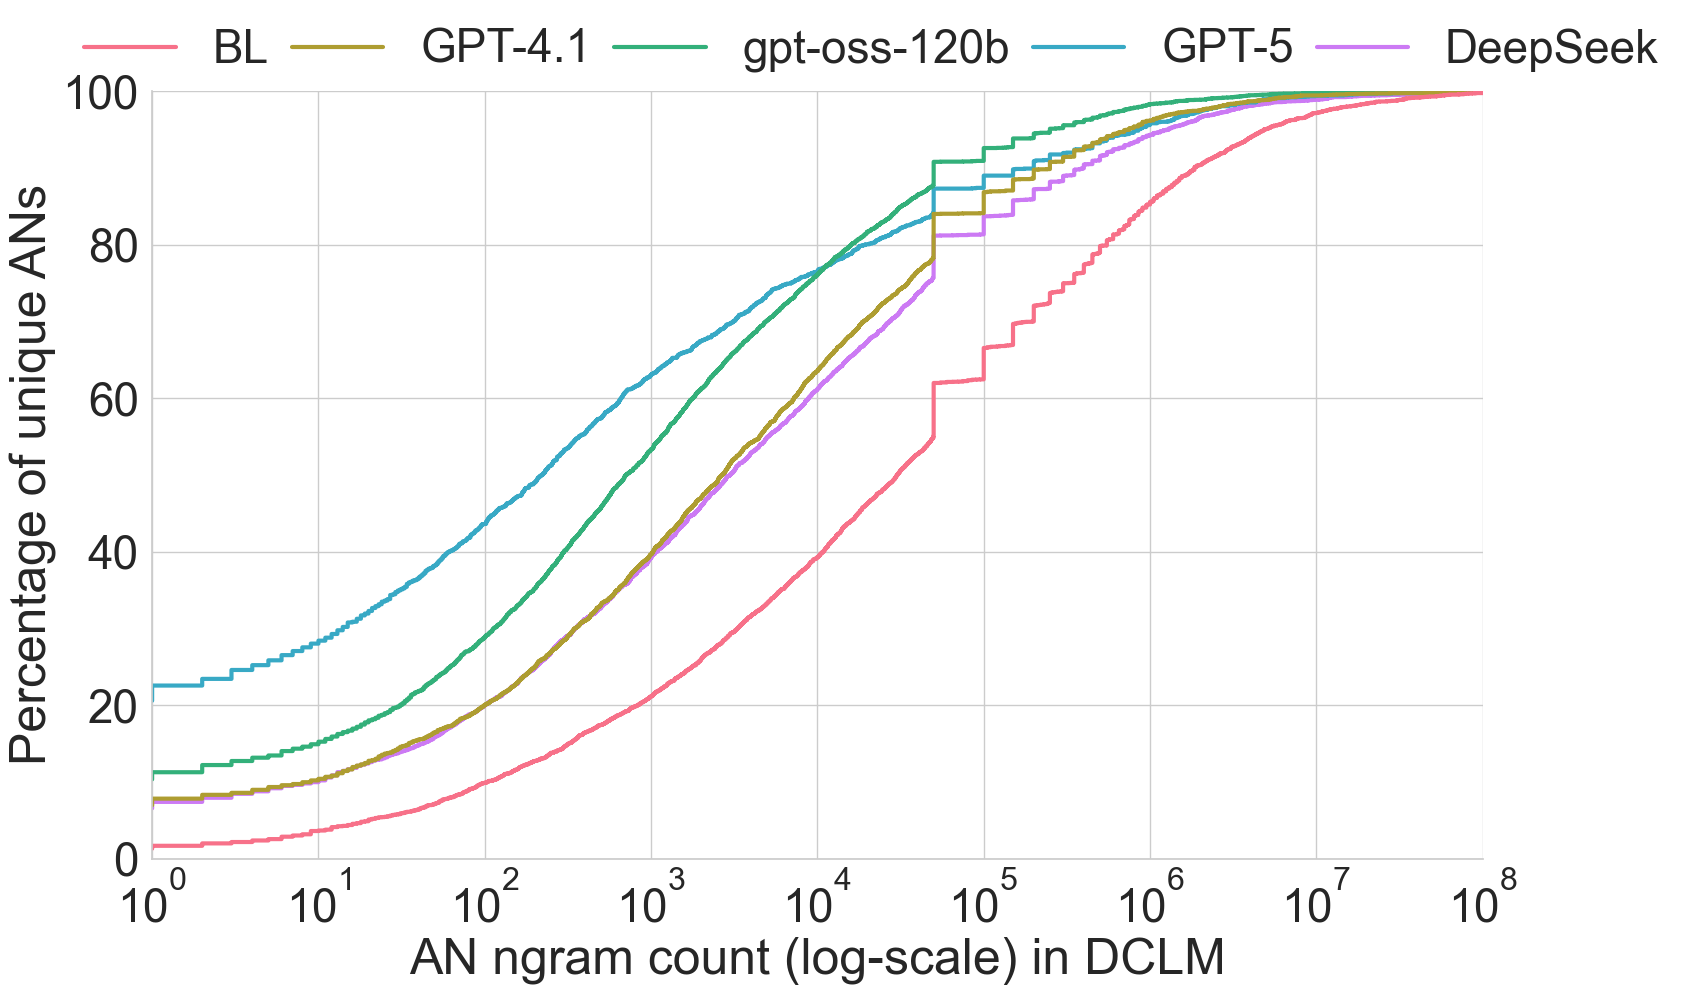

In [8]:
fig = sns.displot(an_df[(an_df.type.isin(['BL', 'GPT-4.1', 'gpt-oss-120b','GPT-5','DeepSeek']))], hue_order=['BL', 'GPT-4.1', 'gpt-oss-120b','GPT-5','DeepSeek'], x='count', hue='type', kind='ecdf', aspect=1.6, height=10, log_scale=(True,False), linewidth=3, stat='percent', palette='husl')
fig.set_axis_labels('AN ngram count (log-scale) in DCLM','Percentage of unique ANs')
sns.move_legend(fig, "upper center", bbox_to_anchor=(.45, 1.05), ncol=5, title=None, frameon=False, columnspacing=0.5)
fig.set(yticks=[i for i in range(0,101,20)])
plt.xlim(1, 10**8) 
plt.ylim(0, 100) 
plt.show()
fig.figure.savefig('an-plot-syn.pdf', bbox_inches='tight')

In [47]:
print(round(an_df[an_df['type']=='GPT-5'].shape[0]/len(gpt5_sents), 2),
round(an_df[an_df['type']=='crowd-first'].shape[0]/len(crowd_sents), 2),
round(an_df[an_df['type']=='combo-humor'].shape[0]/len(comb_sents), 2),
round(an_df[an_df['type']=='DeepSeek'].shape[0]/len(deep_sents), 2),
round(an_df[an_df['type']=='BL'].shape[0]/bl.shape[0], 2))

2.07 0.77 0.55 4.28 2.51


In [20]:
an_df[((an_df['type']=='GPT-5') & (an_df['count']<10))]

,type,an,count
7261,gpt5,anti-gravity mustache,0
7262,gpt5,tragic omelet,0
7263,gpt5,brocadeed accordion,0
7268,gpt5,moonless noon,0
7270,gpt5,unblinking monocle,0
...,...,...,...
9310,gpt5,velveteen hush,5
9314,gpt5,overripe chandelier,0
9315,gpt5,sluggish walrus,9
9320,gpt5,twelfthish year,0


In [22]:
an_df[((an_df['type']=='BL') & (an_df['count']<10))]

,type,an,count
23,bulwer,petrified pharaoh,1
65,bulwer,severe lactophobia,1
68,bulwer,effluvial smell,9
119,bulwer,tasty blowfly,9
138,bulwer,ragged tickets,9
...,...,...,...
4348,bulwer,corporate mcbump,0
4377,bulwer,Palestinian prune,1
4392,bulwer,dormie night,4
4448,bulwer,insentient travelers,0


In [61]:
an_df[((an_df['type']=='gpt-oss-120b') & (an_df['count']<10))]

,type,an,count
14661,gpt-oss-120b,ember­kissed moths,0
14674,gpt-oss-120b,amber–wreathed memories,0
14675,gpt-oss-120b,unholy expedition,0
14677,gpt-oss-120b,syncopated agony,8
14679,gpt-oss-120b,soggy rumors,0
...,...,...,...
18781,gpt-oss-120b,olated secrets,0
18792,gpt-oss-120b,mutinous parrots,0
18798,gpt-oss-120b,ambered murmurs,0
18814,gpt-oss-120b,moonlit mozzarella,9


In [63]:
an_df[((an_df['type']=='GPT-4.1') & (an_df['count']<10))]

,type,an,count
6538,GPT-4.1,anti-gravity mustache,0
6541,GPT-4.1,cosmic cheeseboard,0
6561,GPT-4.1,deafening falcon,0
6562,GPT-4.1,filmy crinolines,0
6563,GPT-4.1,dimest shadows,0
...,...,...,...
10350,GPT-4.1,pun-expected calamities,0
10357,GPT-4.1,narcoleptic willows,0
10358,GPT-4.1,pun-ishing life,0
10365,GPT-4.1,gelatinous moons,0


In [64]:
an_df[((an_df['type']=='DeepSeek') & (an_df['count']<10))]

,type,an,count
10382,DeepSeek,dubious grog,0
10388,DeepSeek,opulent amethyst,6
10400,DeepSeek,ghostly quadrille,0
10409,DeepSeek,enchanted paperweight,4
10425,DeepSeek,assertive sculpting,0
...,...,...,...
14620,DeepSeek,feisty seamstress,0
14635,DeepSeek,untrustworthy camels,0
14638,DeepSeek,indifferent suppers,0
14641,DeepSeek,rogue loaf,1


In [58]:
an_df[((an_df['type']=='combo-humor') & (an_df['count']<10))]

,type,an,count
18828,combo-humor,terrible blackbeard,0
18835,combo-humor,grammatic stress,0
18940,combo-humor,duh neighbor,5
18944,combo-humor,underdressed layman,5
18945,combo-humor,Civic Refusing,2
18951,combo-humor,pre-puke warning,7
19008,combo-humor,Anti -Chewing,0
19046,combo-humor,unfaithful kermit,0
19056,combo-humor,andwrinkly grandma,0
19106,combo-humor,sadomasochistic member,0


In [60]:
an_df[((an_df['type']=='crowd-first') & (an_df['count']<10))]

,type,an,count
21791,crowd-first,non-nondescript theories,3
21893,crowd-first,second \u2014,4
21968,crowd-first,chief sea\u00adport,0
21976,crowd-first,ordinary wjem,0
21990,crowd-first,lenselike quality,2
22037,crowd-first,splendored splend,0
22080,crowd-first,legged lupine,0
22123,crowd-first,ghastly armoire,0
22280,crowd-first,tender bibbi,1
22340,crowd-first,mean loudmouths,8


In [145]:
round(an_df[((an_df['type']=='crowd-first') & (an_df['count']<100))].shape[0]/an_df[an_df['type']=='crowd-first'].shape[0], 2)

0.04

In [144]:
round(an_df[((an_df['type']=='combo-humor') & (an_df['count']<100))].shape[0]/an_df[an_df['type']=='combo-humor'].shape[0], 2)

0.06

In [143]:
round(an_df[((an_df['type']=='BL') & (an_df['count']<100))].shape[0]/an_df[an_df['type']=='BL'].shape[0], 2)

0.1

In [109]:
round(an_df[((an_df['type']=='GPT-5') & (an_df['count']<1000))].shape[0]/an_df[an_df['type']=='GPT-5'].shape[0], 2)

0.63

In [111]:
round(an_df[((an_df['type']=='DeepSeek') & (an_df['count']<1000))].shape[0]/an_df[an_df['type']=='DeepSeek'].shape[0], 2)

0.39

In [9]:
an_df[an_df['type']=='combo-humor'].shape[0]

2963

In [10]:
an_df[an_df['type']=='crowd-first'].shape[0]

767

In [11]:
len(comb_df)

5416